# 3.1 Activation Functions and Gradients

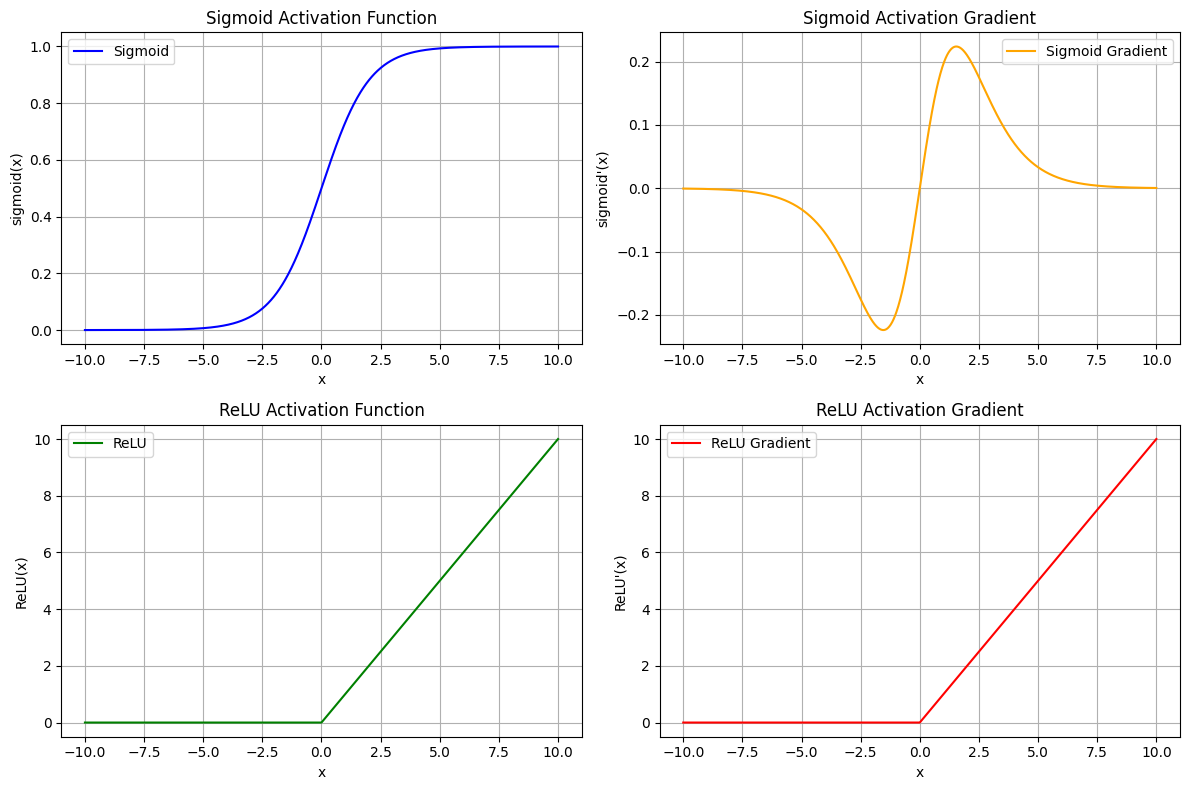

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class Activation:
    def forward(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def backward(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError

class Sigmoid(Activation):
    # sigmoid activation function
    # given as 1 / (1+e^-x)
    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = x
        self.out = np.where(x >= 0,
                            1 / (1 + np.exp(-x)),
                            np.exp(x) / (1 + np.exp(x))
                        )
        return self.out

    # derivative of sigmoid function
    # given as sigmoid * (1 - sigmoid)
    def backward(self, grad_out: np.ndarray) -> np.ndarray:
        return grad_out * self.out * (1 - self.out)

class ReLU(Activation):
    # ReLU activation function
    # given as 0 for x < 0 and x for x >= 0
    def forward(self, x: np.ndarray) -> np.ndarray:
        self.x = x
        return np.maximum(0, x)

    # derivative of ReLU function
    # given as 0 for x < 0 and 1 for x >= 0
    def backward(self, grad_out: np.ndarray) -> np.ndarray:
        relu_grad = (self.x > 0).astype(float)
        return grad_out * relu_grad


x = np.linspace(-10, 10, 1000)

sigmoid = Sigmoid()
relu = ReLU()

# forward pass and gradients
sigmoid_forward = sigmoid.forward(x)
sigmoid_gradient = sigmoid.backward(x)

relu_forward = relu.forward(x)
relu_gradient = relu.backward(x)

# 2x2 grid for plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Sigmoid Activation Function
axs[0, 0].plot(x, sigmoid_forward, label='Sigmoid', color='blue')
axs[0, 0].set_title('Sigmoid Activation Function')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('sigmoid(x)')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Sigmoid Gradient
axs[0, 1].plot(x, sigmoid_gradient, label="Sigmoid Gradient", color='orange')
axs[0, 1].set_title('Sigmoid Activation Gradient')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel("sigmoid'(x)")
axs[0, 1].legend()
axs[0, 1].grid(True)

# ReLU Activation Function
axs[1, 0].plot(x, relu_forward, label='ReLU', color='green')
axs[1, 0].set_title('ReLU Activation Function')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('ReLU(x)')
axs[1, 0].legend()
axs[1, 0].grid(True)

# ReLU Gradient
axs[1, 1].plot(x, relu_gradient, label="ReLU Gradient", color='red')
axs[1, 1].set_title('ReLU Activation Gradient')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel("ReLU'(x)")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

# 3.2 Two-Layer Perceptron


Final Training Performance:
Loss: 0.5973, Accuracy: 0.6406

Test Performance:
Loss: 0.6103, Accuracy: 0.5944


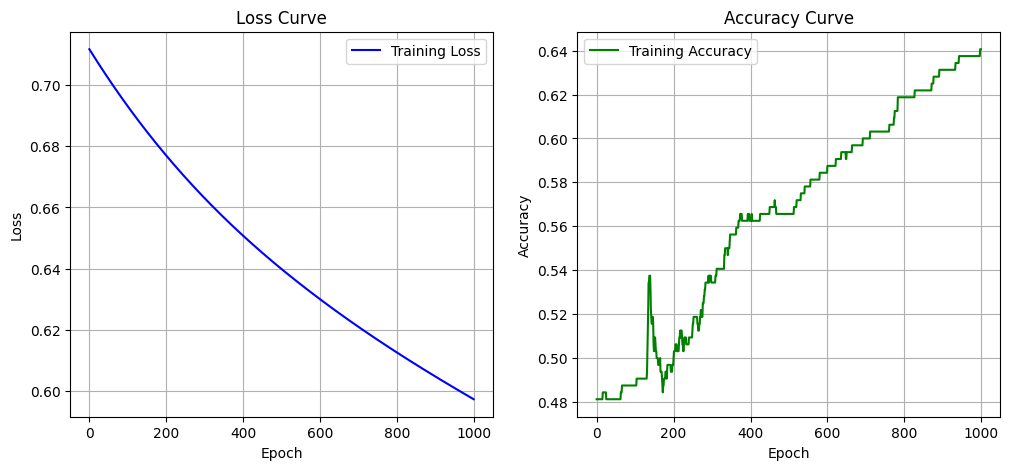

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

def load_data():
    X, y = make_circles(noise=0.15, factor=0.3, random_state=1, n_samples=500)
    y = y.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.36, random_state=42)
    return X_train, X_test, y_train, y_test

# Dense Class
class Dense:
    def __init__(self, input_size, output_size, initialization='he'):
        self.input_size = input_size
        self.output_size = output_size
        if initialization == 'he':
            # He initialization for layers with ReLU activation
            self.W = np.random.randn(input_size, output_size) * np.sqrt(2. / input_size)
        elif initialization == 'xavier':
            # Xavier/Glorot initialization for sigmoid output
            self.W = np.random.randn(input_size, output_size) * np.sqrt(1. / input_size)

        self.b = np.zeros((1, output_size))

    def forward(self, x):
        self.x = x
        self.out = np.dot(x, self.W) + self.b
        return self.out

    def backward(self, grad_out):
        # gradients for weights and biases.
        self.grad_W = np.dot(self.x.T, grad_out)
        self.grad_b = np.sum(grad_out, axis=0, keepdims=True)
        grad_input = np.dot(grad_out, self.W.T)
        return grad_input

    def update(self, lr):
        self.W -= lr * self.grad_W
        self.b -= lr * self.grad_b


# Network Class
class Network:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad):
        # propagate gradients backward through layers
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def update(self, lr):
        # update parameters in all layers
        for layer in self.layers:
            if hasattr(layer, 'update'):
                layer.update(lr)

    def __call__(self, x):
        return self.forward(x)

# Binary cross entropy loss Class
class BinaryCrossEntropyLoss:
    def loss(self, y_true, y_pred):
        epsilon = 1e-12
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss

    def gradient(self, y_true, y_pred):
        # when using sigmoid at the output, the gradient simplifies to (y_pred - y_true)/n.
        grad = (y_pred - y_true) / y_true.shape[0]
        return grad



# hyperparameters and model setup
hidden_size = 16
learning_rate = 0.01
epochs = 1000

# network: input (2 features) -> Dense(hidden_size) -> ReLU -> Dense(1) -> Sigmoid
model = Network([
    Dense(2, hidden_size, initialization='he'),
    ReLU(),
    Dense(hidden_size, 1, initialization='xavier'),
    Sigmoid()
])

criterion = BinaryCrossEntropyLoss()
X_train, X_test, y_train, y_test = load_data()


loss_history = []
accuracy_history = []

for epoch in range(1, epochs + 1):
    # forward pass
    out = model(X_train)
    grad_loss = criterion.loss(y_train, out)
    predictions = (out > 0.5).astype(int)
    accuracy = np.mean(predictions == y_train)

    # record histories for plotting
    loss_history.append(grad_loss)
    accuracy_history.append(accuracy)

    # backward pass and parameter update
    grad_loss = criterion.gradient(y_train, out)
    model.backward(grad_loss)
    model.update(learning_rate)

    # progress every 10 epochs.
    if epoch % 10 == 0:
        loss = criterion.loss(y_train, out)
        acc = (np.where(out > 0.5, 1, 0) == y_train).mean()

        #print(f"Epoch: {epoch}, Loss: {loss}, Accuracy: {acc}")




# performance and Learning Curves
print("\nFinal Training Performance:")
print(f"Loss: {loss_history[-1]:.4f}, Accuracy: {accuracy_history[-1]:.4f}")

# evaluate on test data
test_out = model(X_test)
test_loss = criterion.loss(y_test, test_out)
test_predictions = (test_out > 0.5).astype(int)
test_accuracy = np.mean(test_predictions == y_test)
print("\nTest Performance:")
print(f"Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# plot learning curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(loss_history, label="Training Loss", color='blue')
ax1.set_title("Loss Curve")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

ax2.plot(accuracy_history, label="Training Accuracy", color='green')
ax2.set_title("Accuracy Curve")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.show()


# 3.3 Impact of Normalization Schemes

Training Network (No Normalization)

Training Input Standardization Network

Training Batch Normalization Network


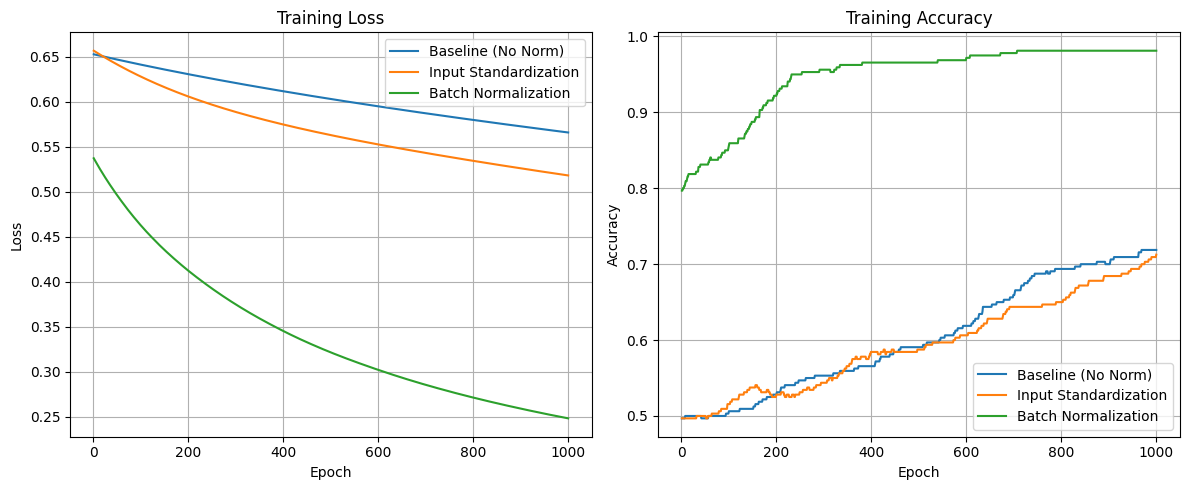


Final Performance:
Baseline:             Train Acc = 0.7188, Test Acc = 0.6778
Input Standardization: Train Acc = 0.7125, Test Acc = 0.6778
Batch Normalization:   Train Acc = 0.9812, Test Acc = 0.9722


In [ ]:
class BatchNormalization:
    def __init__(self, feature_size, epsilon=1e-5):
        self.epsilon = epsilon
        self.gamma = np.ones((1, feature_size))
        self.beta = np.zeros((1, feature_size))

    def forward(self, x):
        self.x = x
        self.mu = np.mean(x, axis=0, keepdims=True)
        self.var = np.var(x, axis=0, keepdims=True)
        # x_hat = x - mu / sqrt(var + epsilon)
        self.x_hat = (x - self.mu) / np.sqrt(self.var + self.epsilon)

        # y = gamma * x_hait + beta
        y = self.gamma * self.x_hat + self.beta
        return y

    def backward(self, grad_out):
        m = self.x.shape[0]
        # gradients for gamma and beta
        self.grad_gamma = np.sum(grad_out * self.x_hat, axis=0, keepdims=True)
        self.grad_beta = np.sum(grad_out, axis=0, keepdims=True)
        # backprop through the normalization
        dxhat = grad_out * self.gamma
        dvar = np.sum(dxhat * (self.x - self.mu) * -0.5 * (self.var + self.epsilon)**(-1.5), axis=0, keepdims=True)
        dmu = np.sum(dxhat * -1 / np.sqrt(self.var + self.epsilon), axis=0, keepdims=True) + dvar * np.mean(-2*(self.x - self.mu), axis=0, keepdims=True)
        dx = dxhat / np.sqrt(self.var + self.epsilon) + dvar * 2 * (self.x - self.mu) / m + dmu / m
        return dx

    # update learnable parameters gamma and beta using gradient descent
    def update(self, lr):
        self.gamma -= lr * self.grad_gamma
        self.beta  -= lr * self.grad_beta

def train_model(model, X_train, y_train, X_test, y_test, lr):
    criterion = BinaryCrossEntropyLoss()
    loss_history = []
    accuracy_history = []
    epochs = 1000

    for epoch in range(1, epochs +1):
        # forward pass on training data
        out = model(X_train)
        loss = criterion.loss(y_train, out)
        preds = (out > 0.5).astype(int)
        acc = np.mean(preds == y_train)

        # keep track of history for plot
        loss_history.append(loss)
        accuracy_history.append(acc)

        # backward pass
        grad_loss = criterion.gradient(y_train, out)
        model.backward(grad_loss)
        model.update(lr)

        #if epoch % 100 == 0:
            #print(f"Epoch {epoch}: Loss={loss:.4f}, Accuracy={acc:.4f}")

    # final training performance
    train_preds = (model(X_train) > 0.5).astype(int)
    train_acc = np.mean(train_preds == y_train)
    # test performance
    test_out = model(X_test)
    test_preds = (test_out > 0.5).astype(int)
    test_acc = np.mean(test_preds == y_test)
    return loss_history, accuracy_history, train_acc, test_acc

# Network 1: no normalization
np.random.seed(42)
model_baseline = Network([
    Dense(2, hidden_size, initialization='he'),
    ReLU(),
    Dense(hidden_size, 1, initialization='xavier'),
    Sigmoid()
])
print("Training Network (No Normalization)")
loss_baseline, acc_baseline, train_acc_baseline, test_acc_baseline = train_model(
    model_baseline, X_train, y_train, X_test, y_test, learning_rate
)

# Network 2: input standardization
# compute training statistics (mu and std) on X_train only.
train_mu = np.mean(X_train, axis=0, keepdims=True)
train_std = np.std(X_train, axis=0, keepdims=True) + 1e-8  # add epsilon to avoid division by zero
X_train_std = (X_train - train_mu) / train_std
X_test_std  = (X_test - train_mu) / train_std

np.random.seed(42)
model_input_std = Network([
    Dense(2, hidden_size, initialization='he'),
    ReLU(),
    Dense(hidden_size, 1, initialization='xavier'),
    Sigmoid()
])
print("\nTraining Input Standardization Network")
loss_input_std, acc_input_std, train_acc_input_std, test_acc_input_std = train_model(
    model_input_std, X_train_std, y_train, X_test_std, y_test, learning_rate
)

# Network 3: Batch Normalization
np.random.seed(42)
model_batch_norm = Network([
    Dense(2, hidden_size, initialization='he'),
    ReLU(),
    BatchNormalization(hidden_size), # perform after hidden layer activation
    Dense(hidden_size, 1, initialization='xavier'),
    Sigmoid()
])
print("\nTraining Batch Normalization Network")
loss_batch_norm, acc_batch_norm, train_acc_batch_norm, test_acc_batch_norm = train_model(
    model_batch_norm, X_train, y_train, X_test, y_test, learning_rate
)




# training curves
epochs_range = np.arange(1, 1001)
plt.figure(figsize=(12, 5))

# loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_baseline, label="Baseline (No Norm)")
plt.plot(epochs_range, loss_input_std, label="Input Standardization")
plt.plot(epochs_range, loss_batch_norm, label="Batch Normalization")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc_baseline, label="Baseline (No Norm)")
plt.plot(epochs_range, acc_input_std, label="Input Standardization")
plt.plot(epochs_range, acc_batch_norm, label="Batch Normalization")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# final Performances
print("\nFinal Performance:")
print(f"Baseline:             Train Acc = {train_acc_baseline:.4f}, Test Acc = {test_acc_baseline:.4f}")
print(f"Input Standardization: Train Acc = {train_acc_input_std:.4f}, Test Acc = {test_acc_input_std:.4f}")
print(f"Batch Normalization:   Train Acc = {train_acc_batch_norm:.4f}, Test Acc = {test_acc_batch_norm:.4f}")

# 3.4 Extending to Multi-Class Classification

Epoch 100: Loss = 1.7129, Accuracy = 0.4662
Epoch 200: Loss = 1.0873, Accuracy = 0.4950
Epoch 300: Loss = 0.7849, Accuracy = 0.6925
Epoch 400: Loss = 0.6646, Accuracy = 0.7362
Epoch 500: Loss = 0.5941, Accuracy = 0.7538
Epoch 600: Loss = 0.5438, Accuracy = 0.7550
Epoch 700: Loss = 0.5067, Accuracy = 0.7550
Epoch 800: Loss = 0.4797, Accuracy = 0.9500
Epoch 900: Loss = 0.4602, Accuracy = 0.9363
Epoch 1000: Loss = 0.4447, Accuracy = 0.9350

Final Training Accuracy: 0.9350
Test Accuracy: 0.9050


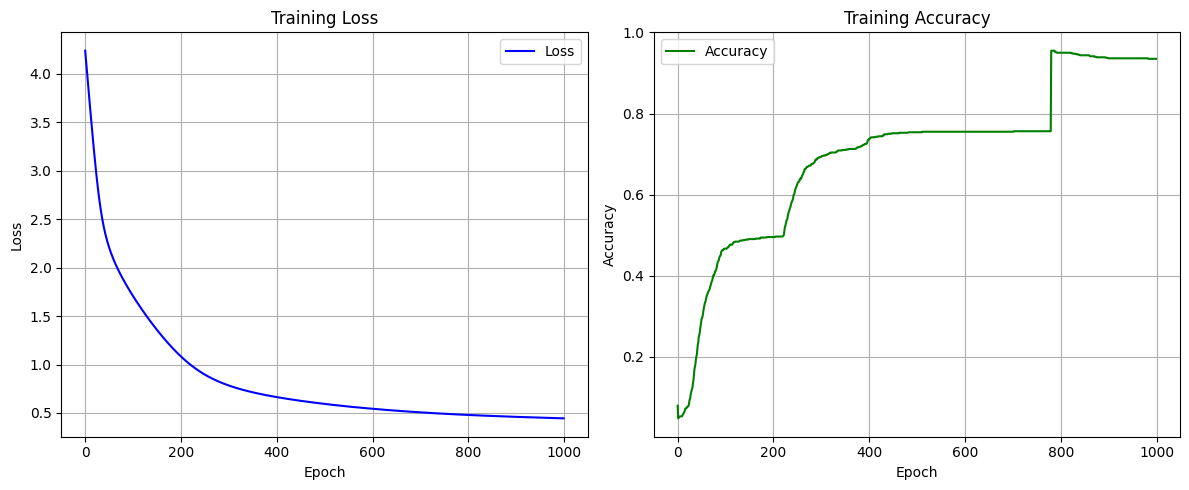

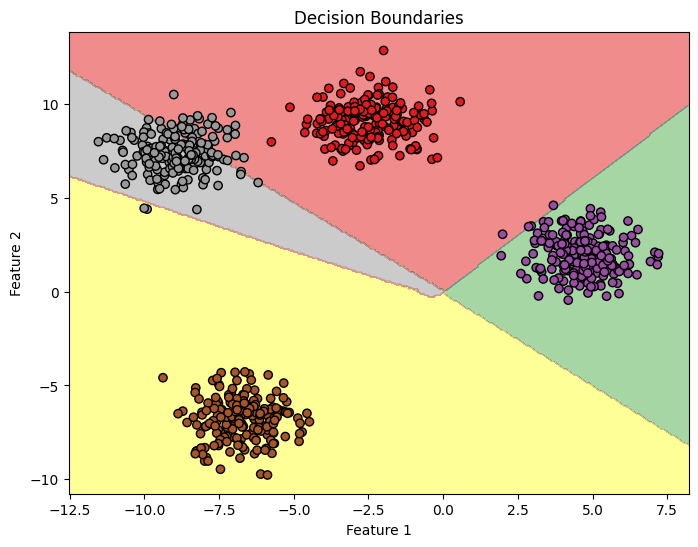

In [ ]:
from sklearn.datasets import make_blobs

# data Generation and Preprocessing

# synthetic 4-class dataset.
X, y = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encoding function
def one_hot_encode(y, num_classes):
    y = y.flatten()  # Ensure shape is (n,)
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

num_classes = 4
y_train_oh = one_hot_encode(y_train, num_classes)
y_test_oh  = one_hot_encode(y_test, num_classes)

class Softmax:
    def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.out = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.out

    def backward(self, grad_out):
        # we pass the gradient through because gradient simplifies to (softmax - one_hot)/N
        return grad_out

    def update(self, lr):
        pass

class CategoricalCrossEntropyLoss:
    def loss(self, y_true, y_pred):
        epsilon = 1e-12  # to avoid log(0)
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        loss = - np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        return loss

    def gradient(self, y_true, y_pred):
        # for softmax + cross-entropy, the gradient simplifies to (y_pred - y_true)/N.
        return (y_pred - y_true) / y_true.shape[0]


# Building the Two-Layer Network

# network: Dense(2 -> hidden_size) -> ReLU -> Dense(hidden_size -> 4) -> Softmax.
hidden_size = 10
learning_rate = 0.001
epochs = 1000

np.random.seed(42)

model = Network([
    Dense(2, hidden_size, initialization='he'),
    ReLU(),
    Dense(hidden_size, num_classes, initialization='xavier'),
    Softmax()
])

criterion = CategoricalCrossEntropyLoss()


# training Loop
loss_history = []
accuracy_history = []

for epoch in range(1, epochs+1):
    # forward pass
    out = model(X_train)
    loss = criterion.loss(y_train_oh, out)
    loss_history.append(loss)

    # training accuracy
    preds = np.argmax(out, axis=1)
    acc = np.mean(preds == y_train)
    accuracy_history.append(acc)

    # backward pass
    grad_loss = criterion.gradient(y_train_oh, out)
    model.backward(grad_loss)
    model.update(learning_rate)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")


# final training and test evaluation
train_preds = np.argmax(model(X_train), axis=1)
train_acc = np.mean(train_preds == y_train)
print(f"\nFinal Training Accuracy: {train_acc:.4f}")

test_out = model(X_test)
test_preds = np.argmax(test_out, axis=1)
test_acc = np.mean(test_preds == y_test)
print(f"Test Accuracy: {test_acc:.4f}")


# plotting training curves loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label="Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# plotting decision boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

# predict class for each grid point
grid_out = model(grid)
grid_preds = np.argmax(grid_out, axis=1).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, grid_preds, alpha=0.5, cmap=plt.cm.Set1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Set1)
plt.title("Decision Boundaries")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()